# Binary shapes in 2D
### Simulation written by Rachael Skye and Maya Martirossyan

### Preparation

In [1]:
#Cell 1

print("hello")

In [2]:
#Cell 2

# !tar -xzf ./hoomd-v2.9.7.tar.gz
#!pip install pip-tools
#!pip-compile requirements.txt

In [3]:
#Cell 3

# importing modules

import hoomd
import hoomd.hpmc as hpmc
import coxeter
import ipywidgets as widgets
import gsd, gsd.hoomd
import numpy as np
import matplotlib.pyplot as pp
import random
import rowan
#%gui qt

### Helper Functions

Setting up some functions that we will use throughout our simulation code. These need to be evaluated, but do not need to be interacted with.  If you have time, you can read through this section to understand what is happening, but if you don't then skip down Choosing Parameters

In [4]:
#Cell 4

# Functions for defining shapes

get_3D_Shape = coxeter.families.RegularNGonFamily()

def make3D(vertex_list):
    """
    input: vertex_list for 2D shapes
    output: vertex_list for same shapes but "in 3D"
    """
    to_add = np.transpose([np.zeros(len(vertex_list))])
    vertex_list = np.concatenate([vertex_list,to_add],axis=1)
    return vertex_list

def get_shape(vertex_count):
    shape = get_3D_Shape.make_vertices(vertex_count)
    scale = 1/np.linalg.norm(shape[0]-shape[1])
    scaled_shape = shape * scale
    
    return make3D(scaled_shape)


#Colors of each shape
# setting colors
# RGB values between 0 and 1
color_A = np.float32(np.divide([255, 50, 150], 255)) #pink
color_B = np.float32(np.divide([0, 200, 100], 255)) #green
colors = [color_A, color_B]

In [5]:
#Cell 5
# Functions for initializing the simulation with HOOMD

def initialize(num_particles): 
    init = hoomd.init.create_lattice(unitcell=hoomd.lattice.unitcell(N=2,
                                                                  a1=[3,0,0],
                                                                  a2=[0,6,0],
                                                                  a3=[0,0,1],
                                                                  dimensions=2,
                                                                  position=[[0,0,0],
                                                                            [0,3,0]],
                                                                  type_name=["A","B"]),
                                n=[num_particles,int(1/2*num_particles)])
    return(init)
    
    
def set_shape_proportion(system, ratio):
    # taking snapshot of the first frame
    snap = system.take_snapshot()

    # defining particle types
    snap.particles.types = ["A","B"]

    nParticles = len(snap.particles.typeid)
    
    # first, assign all particles to be type B
    for p in range(nParticles):
        snap.particles.typeid[p] = 1
    
    # next, randomly assign certain particles to be type A
    partnum_A = int(nParticles*ratio)
    idlistA=[]
    for p in range(partnum_A):
        r = random.randint(0, nParticles - 1)
        while r in idlistA:
            r = random.randint(0, nParticles - 1)
        snap.particles.typeid[r] = 0
        idlistA.append(r)
        
    return snap

def start_monte_carlo():
    return hpmc.integrate.convex_polygon(seed=np.random.randint(1,1e6), d=0.5, a=0.5, move_ratio=0.5)

def start_box_mc(total_steps,max_pressure):
    return hpmc.update.boxmc(monte_carlo, hoomd.variant.linear_interp(points=[[0,1],[total_steps,max_pressure]],zero=0), 
                          np.random.randint(1,1e6))

In [6]:
#Cell 6
# Functions for visualizing our simulation
       
def getFrameCount(fname):
    """
    inputs: fname, the filename (ex: 'dump.gsd')
    outputs: len(traj), number of frames in simulation
    """
    with gsd.hoomd.open(fname, 'rb') as traj:
        return len(traj)
    
def drawFrame(frame, vertices, boxLimit):
    pp.figure(figsize=(10,10))
    
    for p in range(len(frame.particles.position)):
            pos = frame.particles.position[p]
            unrotatedVerts = vertices[frame.particles.typeid[p]]
            orientation = frame.particles.orientation[p]
            
            rotatedVerts = rowan.rotate(orientation,unrotatedVerts)
            location= rotatedVerts + pos
            x = location[:, 0]
            y = location[:, 1]
            color = colors[frame.particles.typeid[p]]

            pp.fill(x, y, color = color)
            
            pp.xlim(-boxLimit, boxLimit)
            pp.ylim(-boxLimit, boxLimit)
    

### Choosing parameters

This includes choosing the two shapes we will be using, the proportion of each shape, and the total number of shapes in the simulation box. Here, user input is important! 

As a scientist, you will want to also make a prediction (hypothesis) at this point. Think about how the simulation outcome might depend on your choice of shapes and their ratio. A good experiment also only changes one thing at a time -- decide which parameter you'd like to vary and which you'd like to keep constant.

In [7]:
#Cell 7
# we will be using regular polygons for our shapes

# choose shapes by the number of vertices that shape has
# Example: verticesA = get_shape(3) will choose triangles for shapeA
verticesA = get_shape(3)
verticesB = get_shape(6)

In [8]:
#cell 8
# choose a fraction between 0 and 1
# which will represent the percent of shapes that are shape A
# example:
# shape_proportion = 0 means all the shapes will be shape B

shape_proportion = 0.5

In [9]:
#Cell 9
# setting number of particles along one side of our simulation box
# which is the square root of the total number of particles

num_particles_sqrt = 10

### Initializing the simulation

Here, we will use the functions for simulation initialization written above, and execute them with the inputs given by the user. We can then visualize what we've initialized -- the first frame of the simulation.

In [10]:
#Cell 10
hoomd.context.initialize("--mode=cpu");

# defining the first frame of our simulation
# set up lattice of particles
system = initialize(num_particles_sqrt)

#Set the system to have the correct shape proportion
system_with_shapes = set_shape_proportion(system, shape_proportion)
    
system.restore_snapshot(system_with_shapes)

boxSize = system.box.Lx

HOOMD-blue 2.9.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 06/26/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 100 particles


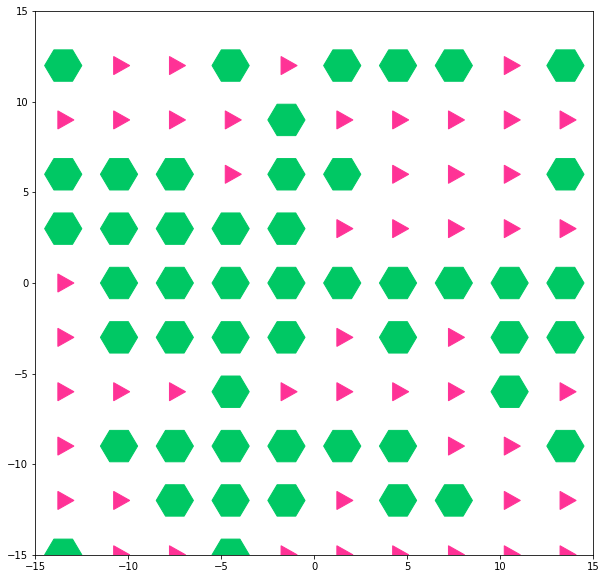

In [11]:
#Cell 11
# visualizing our initial frame

initial_frame = system.take_snapshot()

drawFrame(initial_frame, [verticesA, verticesB], 1/2 * boxSize)    

Now, we need to set parameters for the simulation itself. This has a couple steps -- first, we set some basic parameters, such as timesteps, pressure, and how 'hard' we are shaking our simulation box (more technically, how large our steps/rotations are).

In [12]:
#Cell 12
#simulation parameters

# pressure and time settings
total_steps = 2e5
max_pressure = 10

#Monte Carlo simulation settings for the particles
monte_carlo = start_monte_carlo()

#pass in our chosen shapes
monte_carlo.shape_param.set('A', vertices=verticesA)
monte_carlo.shape_param.set('B', vertices=verticesB)

#Monte Carlo settings for the "box" which applies pressure to the particles
box_monte_carlo = start_box_mc(total_steps, max_pressure)

#Set the box to shrink with "delta"
box_monte_carlo.volume(delta=1.0, weight=1.0);

# define "tuners" that will help the simulation run smoothly
# by adjusting how far particles move in each timestep
particle_tuner = hpmc.util.tune(obj=monte_carlo, tunables=['d','a'], target=0.2)
box_tuner = hpmc.util.tune_npt(obj=box_monte_carlo, tunables=['dV'],  target=0.2)


def update_tuner(particle_tuner, box_tuner):
    particle_tuner.update()
    box_tuner.update()

### Running the simulation

In the next cell, we record the data in the form of a gsd file (with the simulation frames) and a log file (with some simulation parameters that help us see how volume and pressure are changing).

Note: If you have already run a simulation, make sure to update the filename that your new simulation will be saved to (in the second cell below).

In [13]:
#Cell 13
# simulation setup

#begin by choosing a unique filename to save our simulation data under
file_name = "shapeA_" + str(len(verticesA)) + "_shapeB_" + str(len(verticesB)) + "_shape_proportion_" + str(shape_proportion)

print('file name for this simulation is ', file_name)

all=hoomd.group.all()

file name for this simulation is  shapeA_3_shapeB_6_shape_proportion_0.5


In [14]:
#Cell 14
# record data

# for visualizations
movie_file = hoomd.dump.gsd(filename=file_name+'.gsd',period=int(total_steps/100),group=all,overwrite=True)
movie_file.dump_shape(monte_carlo)

# for plots
#record data as specified in "quantities"
data_file = hoomd.analyze.log(filename=file_name+'.txt',
    quantities=['hpmc_d', #how far particles are trying to move
                'lx', #length of box side
                'hpmc_boxmc_betaP', #pressure
                'hpmc_overlap_count' #how many particles are in the same spot. Should always be 0
                ],
    period=int(total_steps/100),
    overwrite=True)

In [ ]:
#Cell 15
# running simulation

# defining number of times we will tune the step size parameters
number_loops = 100
loop_steps = int(total_steps/number_loops)

hoomd.run(total_steps, 
          callback_period = loop_steps, 
          callback = lambda tuner: update_tuner(particle_tuner,box_tuner))

** starting run **
Time 00:00:10 | Step 50862 / 200000 | TPS 5086.16 | ETA 00:00:29


### Visualizing your simulation

Your simulation is now complete! It's time to see what the result was.

In [ ]:
#Cell 16

#make sure to choose the filename corresponding to the simulation you want to watch
#Uncomment the next line (remove the # ) and edit the text in quotes if you want to change the filename.
#file_name = "file_name_here"

frame_num = getFrameCount(file_name + '.gsd')

# visualizations
# looping over frames

@widgets.interact(frame_index=(0, frame_num-1, 1))
def plot(frame_index=0):
    with gsd.hoomd.open(file_name+".gsd", 'rb') as traj:
        
        frame = traj[frame_index]
        box = frame.configuration.box
        
        drawFrame(frame, [verticesA, verticesB], 1/2*boxSize)

        
            

### Plotting simulation data

In [ ]:
#Cell 17

# Make sure to use the right file name
data = np.loadtxt(file_name+'.txt',skiprows=1) #skiprows makes sure we skip the labels on the table

print("loaded data for: " + file_name)

In [ ]:
#Cell 18
# Volume changes with time

#tables are referred to by entry number
#entry 0 is timestep
#entry 2 is the box size
#entry 3 is the pressure

time = data[:,0]
lx = data[:,2]
pressure = data[:,3]

volume = lx ** 2 #square of length is area

pp.scatter(time, volume);
pp.title('Volume change over timesteps');
pp.xlabel('Steps');
pp.ylabel('Volume');

In [ ]:
#Cell 19
# Volume changes with pressure

pp.scatter(pressure, volume);
pp.title('Volume change over pressure');
pp.xlabel('Pressure');
pp.ylabel('Volume');

In [ ]:
#Cell 20
# Zoom in on the part below the initial compression

pp.scatter(pressure, volume);
pp.title('Volume change over pressure');
pp.xlabel('Pressure');
pp.ylabel('Volume');

#change y limits here
pp.ylim(80,100)
#change x limits here
pp.xlim(8,10)

In [ ]:
#Cell 21

#You can do math here just as you would on a calculator. For instance:
#Using + - * /

4/9